In [1]:
from math import *
import matplotlib.pyplot as plt
import numpy as np

# Mathematical Model

**Picker Calculus:**

| Symbol        | Label                        | Units     |
|---------------|------------------------------|-----------|
| $t$           | Universe time                | s         |
| $n$           | Picker operations per second | s $^{-1}$ |
| $T$           | Time per Picker operation    | s         |
| $\gamma$      | Time conversion factor       |           |
| $H$           | Cumulative Harolds' Time     | s         |
| $\mathcal{R}$ | Relative Picker time         | s         |
| $\mathcal{A}$ | Absolute Picker time         | s         |

**Population model:**

| Symbol      | Label                                            | Units            |
|-------------|--------------------------------------------------|------------------|
| $P$         | Population of Universe                           | indiv.           |
| $P_{civ}$   | Population of Universe                           | civs.            |
| $P_0$       | Initial population of Universe                   | indiv.           |
| $K$         | Carrying capacity of Universe                    | indiv.           |
| $K_{world}$ | Carrying capacity of civilizations               | indiv.           |
| $K_{civ}$   | Carrying capacity of civs. in Universe           | civ.             |
| $b$         | Rate of births (for planetary populations)       | indiv. s $^{-1}$ |
| $d$         | Rate of deaths (for planetary populations)       | indiv. s $^{-1}$ |
| $b_T$       | Rate of Transcendentalist-caused births          | civ. s $^{-1}$   |
| $d_T$       | Rate of Transcendentalist-caused deaths          | civ. s $^{-1}$   |
| $r$         | Rate of natural increase (for civs. in Universe) | civ. s $^{-1}$   |

## Absolute Picker Time

The average absolute Picker time, meaning the time they are Picker in relation
to the Universe and not their subjective experience, between two times $t_0$ and
$t_1$ is simply,

$$ \mathcal{A} = \frac{(t_1-t_0)-(H(t_1)-H(t_0))}{D(t_1)-D(t_0)} $$

where the total time (minus the time taken up in the period $t_0$ to $t_1$ by
the Harolds) divided by the number of deaths gives the amount of time per death,
or in between deaths. This is the minimum time each person must be Picker for
all moments in time to have a Picker.

To calculate the "instantenous" Picker time, the following limit is set up,

$$ \mathcal{A}(t) = \lim_{t_1 \to t} \frac{t_1-t-H(t_1)-H(t)}{D(t_1)-D(t)} $$

Solving the limit using the definition of the derivative,

$$ \mathcal{A}(t) = \frac{1-H'(t)}{D'(t)} $$

But due to the low number of Harolds,

$$ \boxed{\mathcal{A}(t) \approx \frac{1}{D'(t)}} $$

All units here are in seconds, but for the Python calculations will often be
done in Ma (millions of years).

## Relative Picker Time

To convert from absolute Picker time to relative Picker time (the time actually
experienced by the Picker themselves), the equation

$$ \boxed{\mathcal{R}(t) = \gamma \mathcal{A}(t)} $$

is used where $\gamma$ is the time factor. This means that, for every second in
the real world, the Picker experiences $\gamma$ seconds. (The units of time
don't matter as long as they cancel out). Due to the nature of the Picker's job,
this time factor is massive, leading to the tongue-in-cheek definition of the
Picker's job as Hell. The approximation (ignoring relativity) for $\gamma$ is
given by,

$$ \gamma = nT $$

where $n$ is the number of required Picker operations per unit time and $T$ is
the time per Picker operation.


## Population Model

From here on, $t=0$ is exactly -5000 Ma. At $t=0$, the population, $P_0$, of the
universe is *defined* as exactly the population of one civilized world (10
billion). This is necessary for the equations, but really whatever value this is
has no effect 5 billion years later on the population.

In [2]:
init_pop = 10**10 # world
init_time = -5000 # Ma
end_time = 100 # Ma

Modelling the population of the Universe is the first step to calculating Picker
times and other things. The standard equation for population dynamics is this
logistic differential equation,

$$ \frac{\mathrm{d}P}{\mathrm{d}t} = rP\left(1-\frac{P}{K}\right) $$

$$ r = b - d $$

And in non-differential form,

$$ P(t) = \frac{P_0 K e^{rt}}{(K-P_0) + P_0 e^{rt}} $$

When finding the population at all times in a range, it is easier to numerically
integrate the preivous equation, as will be done in Python.


In [3]:
# Normal model
def pop_change(b, d, pop, carry):
    limiter = (1 - pop/carry)
    diff = (b - d) * pop * limiter
    return diff

def make_pop_data(b, d, init_pop, carry, init_time, end_time, iterator=1):

    time = np.arange(init_time, end_time, iterator)
    pop = np.array([init_pop])
    d_pop = np.array([])

    for i in time:
        change = pop_change(b, d, pop[-1], carry)

        # Edge case where change goes over carry
        if pop[-1] + change > carry:
            pop_fill = np.ones(size(time) - size(pop))*carry
            pop = np.append(pop, pop_fill)
            d_pop_fill = np.zeros(size(time) - size(d_pop))
            d_pop = np.append(pop, d_pop_fill)
            # This may go one over or under for the array sizes, but it is
            # unused so it doesn't really need to work correctly
            break

        d_pop = np.append(d_pop, change)
        pop = np.append(pop, pop[-1] + change)

    pop = pop[0:-1] # pop goes 1 over size(time)

    return time, pop, d_pop


However, that assumes reproduction occurs between members of the population.
While this is true for individual civilizations, the population of civilizations
in the universe is only dependent on the number of planets which *can* become
civilized. Thus, a better equation is,

$$ \frac{\mathrm{d}P}{\mathrm{d}t} = r(K-P) $$

Non-differential form,

$$ P(t) = K - (P_0-K)e^{-rt} $$

This seems to make sense. At any moment in time, the change in the number of
civilizations is equal to the remaining possible planets were civilizations may
emerge times the rate at which *any single planet* gains a civilization. At the
time scales in question, the thousands of years it takes to develop civilization
are ignored. Interstellar colonization is also ignored, as the rate of growth
for this, given the energy requirements to transform worlds were civilizations
can't occur to ones where civilization is possible, is far to low.

It also doesn't make sense to define $r$ as $b-d$ since civilizations don't die
(or are assumed not to for now, ignoring the Transcendentalists' War). Instead,
$r$ is simply the rate of formation of civilizations.

In [4]:
# Civilizational model
def civ_change(r, pop, carry):
    return r * (carry - pop)

def make_civ_data(r, init_pop, carry, init_time, end_time, iterator=1):

    time = np.arange(init_time, end_time, iterator)
    pop = np.array([init_pop])
    d_pop = np.array([])

    for i in time:
        change = civ_change(r, pop[-1], carry)

        # Edge case where change goes over carry
        if pop[-1] + change > carry:
            pop_fill = np.ones(size(time) - size(pop))*carry
            pop = np.append(pop, pop_fill)
            d_pop_fill = np.zeros(size(time) - size(d_pop))
            d_pop = np.append(pop, d_pop_fill)
            # This may go one over or under for the array sizes, but it is
            # unused so it doesn't really need to work correctly
            break

        d_pop = np.append(d_pop, change)
        pop = np.append(pop, pop[-1] + change)

    pop = pop[0:-1] # pop goes 1 over size(time)

    return time, pop, d_pop

    return 0


### Carrying Capacity

Next, $K$ must be calculated. Using results from
[Wikipedia](https://en.wikipedia.org/wiki/Drake_equation#Range_of_results), a
high estimate (meaning a "maximum" possible value, or carrying capacity) of our
galaxy is 15,600,000 civilizations. Since these civilizations have the
technology to communicate into space, it must be assumed that they have similar
technology to Earth, where the carrying capacity is around 10 billion
($K_{world}$). Expanding our galaxy's estimate to all stars in the Universe,
[10e24](https://www.space.com/26078-how-many-stars-are-there.html); and
calculating a Universal ratio of stars with civilizations (using the Milky Way,
$mw$, as reference) by dividing the number of $mw$ civilizations from the total
number of stars in our galaxy, [10e11](https://en.wikipedia.org/wiki/Milky_Way),
$K$ can be calculated as,

$$ K = K_{world} \cdot n_{stars} \cdot
\left(\frac{n_{civs}}{n_{stars}}\right)_{mw} $$

The carrying capcity in terms of civilizations ($K_{civ}$) and not indiviudals
is calculated the same way ignoring the $K_{world}$ term.


In [5]:
# Constants
k_world = 10**10
num_stars_uni = 10**24
num_civs_mw = 1.560 * 10**7
num_stars_mw = 10**11

k_civ = num_stars_uni * (num_civs_mw/num_stars_mw)
k = k_civ * k_world

print(f"K_civ: {k_civ}")
print(f"K: {k}")


K_civ: 1.56e+20
K: 1.56e+30


### Rates of Increase

Finding a rate of natural increase for individual civilizations is easy. On
Earth, [there are many RNI values](https://tinyurl.com/25hl4ebc) per year. This
can be converted to seconds, as with all units.


In [6]:
# Using America as reference as an example

b_america = 12.3/1000 # per year
d_america = 8.4/1000 # per year

r_america_per_year = b_america - d_america
r_america_per_sec = r_america_per_year/(60*60*24*365)  # per year to per second

print(f"r per year: {r_america_per_year}")
print(f"r per second: {r_america_per_sec}")


r per year: 0.003899999999999999
r per second: 1.2366818873668184e-10


Now a sample graph can be made for America with example values.

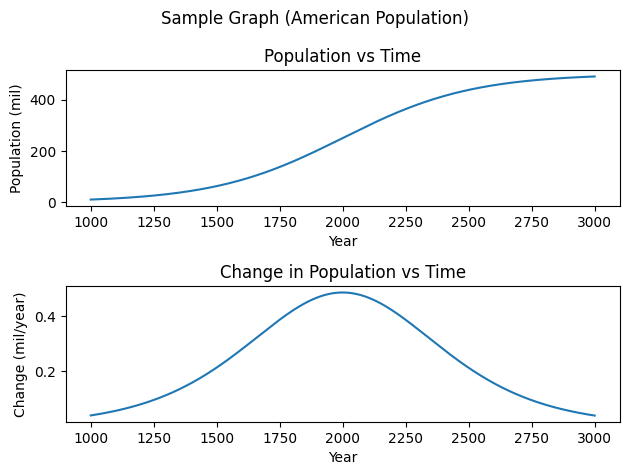

In [7]:
# None of these values are intended to be historically correct, they are choosen
# purely to make the graph look nice

k_america = 500_000_000 / 1_000_000 # in millions
init_pop_america = 10_000_000 / 1_000_000 # in millions

time_america, pop_america, d_pop_america = \
    make_pop_data(b_america, d_america, init_pop_america, k_america, 1000, 3000)

fig1, (fig1_ax1, fig1_ax2) = plt.subplots(2)

fig1.suptitle("Sample Graph (American Population)")

fig1_ax1.plot(time_america, pop_america)
fig1_ax1.set_title("Population vs Time")
fig1_ax1.set_xlabel("Year")
fig1_ax1.set_ylabel("Population (mil)")

fig1_ax2.plot(time_america, d_pop_america)
fig1_ax2.set_title("Change in Population vs Time")
fig1_ax2.set_xlabel("Year")
fig1_ax2.set_ylabel("Change (mil/year)")

fig1.tight_layout()


The next task is to find $r$ for civilizations in the Universe, as this is the
model that works best for the Universe. This is also the last unknown needed
before a graph can be made, since $P_0 = 10^{10}$ and $t = 0$ is -5000 Ma (which
will go to the present time and a bit past it). There is really no way to
estimate what this may be, and all that really matters is that the graph looks
nice. So multiple $r$ values will be graphed to see what looks best.

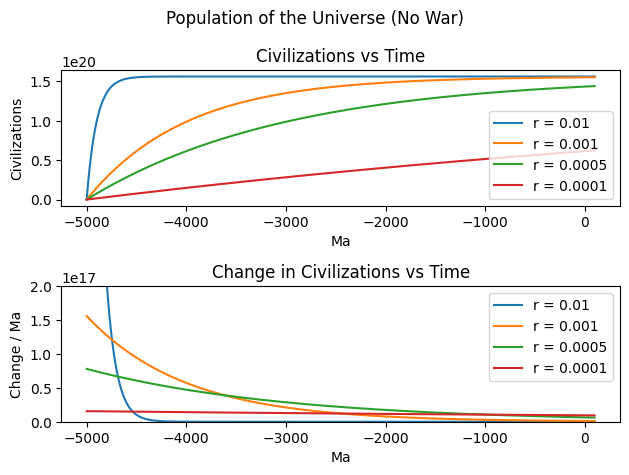

In [8]:
# Possible rates at which all remaining planets become civilized / Ma
r1 = 0.01
r2 = 0.001
r3 = 0.0005
r4 = 0.0001

time1, pop1, d_pop1 = \
    make_civ_data(r1, init_pop, k_civ, init_time, end_time)
time2, pop2, d_pop2 = \
    make_civ_data(r2, init_pop, k_civ, init_time, end_time)
time3, pop3, d_pop3 = \
    make_civ_data(r3, init_pop, k_civ, init_time, end_time)
time4, pop4, d_pop4 = \
    make_civ_data(r4, init_pop, k_civ, init_time, end_time)

fig2, (fig2_ax1, fig2_ax2) = plt.subplots(2)

fig2.suptitle("Population of the Universe (No War)")

fig2_ax1.plot(time1, pop1, label=str(f"r = {r1}"))
fig2_ax1.plot(time2, pop2, label=str(f"r = {r2}"))
fig2_ax1.plot(time3, pop3, label=str(f"r = {r3}"))
fig2_ax1.plot(time4, pop4, label=str(f"r = {r4}"))
fig2_ax1.set_title("Civilizations vs Time")
fig2_ax1.set_xlabel("Ma")
fig2_ax1.set_ylabel("Civilizations")

fig2_ax1.legend()

fig2_ax2.plot(time1, d_pop1, label=str(f"r = {r1}"))
fig2_ax2.plot(time2, d_pop2, label=str(f"r = {r2}"))
fig2_ax2.plot(time3, d_pop3, label=str(f"r = {r3}"))
fig2_ax2.plot(time4, d_pop4, label=str(f"r = {r4}"))
fig2_ax2.set_title("Change in Civilizations vs Time")
fig2_ax2.set_xlabel("Ma")
fig2_ax2.set_ylabel("Change / Ma")
fig2_ax2.set_ylim([0,0.2 * 10**18])
fig2_ax2.legend()

fig2.tight_layout()


The best of these seems to be $r=0.001$, so from here on, the rate at which
planets become civilizations per million years is 0.1%. Now, to calculate Picker
times, which is the entire point of this model, death rates must be found. It
can be assumed that each civilization, once at the carrying capacity, has a
natural, equal birth and death rate. Since the number of civilizations can be
calculated at anytime, the total death rate can too. Finding the total
population of the universe from the number of civilizations and multiplying that
by the death rate gives the number of deaths in any period of time.

Continuing to ignore the Transcendentalists' War, where $P_{civ}$ is the number
of civilizations in the Universe at any given time, the death rate can be
calculated as,

$$ \boxed{\frac{\mathrm{d}D}{\mathrm{d}t} = dK_{world}P_{civ}(t)} $$

The death rate in America, as used earlier, is $r = 0.0084$ per year, or 0.84%.
Rounding, 1% can be used as the natural death rate of all civilizations in the
Universe at carrying capacity, ignoring how it changes with the population and
development of a civilization.

The absolute Picker time at 0 Ma: A = 2.0339195330319226e-21 seconds
A = 0.0020339195330319228 attoseconds


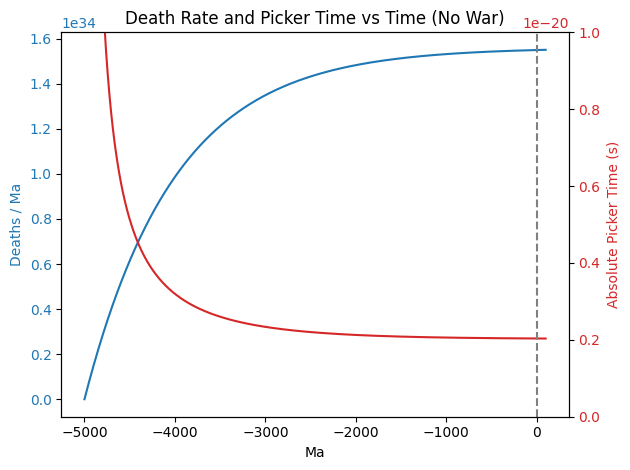

In [9]:
# Taking the choosen r value data
time = time2
pop_civ = pop2
d_pop = d_pop2

d = 0.01 # per year
d = d*1_000_000 # per Ma

death_rate = k_world*d*pop_civ

# Deaths / Ma to deaths / seconds
death_rate_per_sec = death_rate/1_000_000/365/24/60/60

absolute_picker_time = 1/death_rate_per_sec

fig3, fig3_ax1 = plt.subplots()

fig3_ax1.plot(time, death_rate, color='tab:blue')
fig3_ax1.set_title("Death Rate and Picker Time vs Time (No War)")
fig3_ax1.set_xlabel("Ma")
fig3_ax1.set_ylabel("Deaths / Ma", color='tab:blue')
fig3_ax1.tick_params(axis='y', labelcolor='tab:blue')

fig3_ax2 = fig3_ax1.twinx()

fig3_ax2.plot(time, absolute_picker_time, color='tab:red')
fig3_ax2.set_ylabel("Absolute Picker Time (s)", color='tab:red')
fig3_ax2.tick_params(axis='y', labelcolor='tab:red')
fig3_ax2.set_ylim([0,10**-20])
fig3_ax2.vlines(x=0, ymin=0, ymax=10**50, linestyles='dashed', color='gray')

fig3.tight_layout()

print(f"The absolute Picker time at 0 Ma: A = {absolute_picker_time[-1]} seconds")
print(f"A = {absolute_picker_time[-1]*(10**18)} attoseconds")



It takes light 0.247 attoseconds to travel the average bond length of molecular
hydrogen. So, around 120 Pickers control the universe in the time it takes a
photon to cross a hydrogen atom.

## Transcendentalists' War

Let the goal of the Transcendentalists be to maintain a stable absolute Picker
time below the value found above. The War lasts between -130 Ma and 15 Ma, with
its plateau between -100 and -15 Ma. There are two methods to increase the death
rate while maintaining a constant population: 1) increase the birth and death
rate of individual civilizations en masse and 2) increase the birth and death
rate of civilizations themselves in the Universe.

The Transcendentalist civilizations are already assumed to have completed the
first method on their own civilizations. They are, however, such a small
minority of the civilizations in the Universe (although advanced) that they may
be ignored, since the majority are Cascade Theorists. The primary method
Transcendentalists use is civilization seeding and destruction. Basically,
evolved beings capable of creating civilizations are plucked from one planet and
sent to another (capable of hosting civilization) to seed a new civilization.
Then, after a few thousand years, where to planet's population reaches
$K_{world}$, the planet is obliterated. If new planets are being seeded and
destroyed at a significant rate every second, it will have a significant impact
on the total death rate of the Universe.

While, as mentioned earlier, interstellar colonization like this takes too much
energy and ought to be ignored, it is still easier than imposing method 1 on
civilizations. However, it also does not require terraforming and the
Transcendentalists do have access to significant energy.

Thus, the original equation for the growth of civilizations can be adjusted to
include $b$ and $d$ (not to be confused with the $b$ and $d$ of individual
civilizations),

$$ \frac{\mathrm{d}P_{civ}}{\mathrm{d}t} = (b-d)(K_{civ}-P_{civ}) $$

The natural $r$ as found above is 0.1% per Ma. Since $d$ was assumed to be $0$,
it must follow that the natural $b$ is 0.1% per Ma. The Trancendentalists
increase the birth rate of civilizations with seeding and the death rate with
destuction. This destruction is assumed to be instantenous. This creates a new
equation, where the subscript $T$ marks Trancendentalists',

$$ \frac{\mathrm{d}P_{civ}}{\mathrm{d}t} = (r+b_T-d_T)(K_{civ}-P_{civ}) $$

$$ b_T-d_T = 0 $$

The values of $b_T$ and $d_T$ can therefore be anything as long as they are the
same, for the Trancendentalists destroy ever planet they seed. This also results
in a new death rate equation, which must now take into account the previously
absent $d$ for civilizations, each with an assumed poulation of $K_{world}$,

$$ \boxed{\frac{\mathrm{d}D}{\mathrm{d}t}=dK_{world}P(t) + d_T K_{world}P(t)} $$

The next step is to find a function for $d_T(t)$, since the War only occurs in a
set range of time, with ramp up and slow down periods. Assuming the function
should begin at $t=-130$ Ma and end at $t=15$ Ma, with a plateau between
$t=-100$ Ma and $t=-15$ Ma, it can be written as a logistic function,

$$ d_T(t) = \frac{L}{1+e^{-k(t-t_0)}} $$

This *specific* function is really only used to make the graphs look nice and
like $r$ before, the constants are found by looking for a nice graph. In this
case, the nice looking value of $d_T$ was found through trial and error before
making the actual plot.


Civ. population at 0 Ma: 1.549515065343281e+20
d_T at 0 Ma: 6019.68509831322
Civ. population at -50 Ma: 1.548977215497985e+20
d_T at -50 Ma: 15000.0
Worlds destroyed per year (0 Ma): 9.327592748458784e+17
Worlds destroyed per year (-50 Ma): 2.3234658232469775e+18
The absolute Picker time at 0 Ma: A = 1.2704478102769586e-21 seconds
A = 0.0012704478102769587 attoseconds
Change in absolute Picker time at 0 Ma: A' = 1.1309597313076625e-22 seconds/Ma
A' = 0.00011309597313076625 attoseconds/Ma
A' = 1.1309597313076625e-10 attoseconds/year


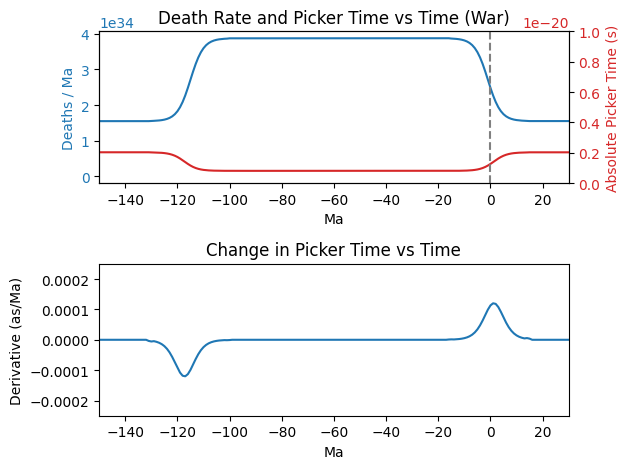

In [10]:
def make_trans_data(supremum, change_rate, carry, pop, time):
    d_trans = np.zeros(np.size(time))
    x = np.linspace(0, supremum, 30)

    # The segement where d_trans changes - a period of 30 Ma
    d_trans_grow_seg = np.zeros(30)

    # Apply logistic curve
    for i in range(0, 30):
        d_trans_grow_seg[i] = supremum / (1 + exp(-change_rate*(i-15)))

    # Copy reversed segement
    d_trans_shrink_seg = np.flip(d_trans_grow_seg)

    # Splices everything together in one array
    d_trans[4870:4900] = d_trans_grow_seg
    d_trans[4900:4985] = supremum
    d_trans[4985:5015] = d_trans_shrink_seg

    # Find the actual number of deaths / unit time
    death_rate_trans = d_trans*carry*pop

    return death_rate_trans, d_trans

max_d_trans = 15_000 # per Ma
k_trans = 0.4 # Sigmoid steepness

death_rate_trans, d_trans = make_trans_data(max_d_trans, k_trans, k_world, pop_civ, time)

# Using the previous death rate and just adding the new deaths
total_death_rate = death_rate + death_rate_trans
total_death_rate_per_sec = total_death_rate/1_000_000/365/24/60/60

absolute_picker_time = 1/total_death_rate_per_sec

d_absolute_picker_time = np.gradient(absolute_picker_time)

# Useful data
print(f"Civ. population at 0 Ma: {pop_civ[5000]}")
print(f"d_T at 0 Ma: {d_trans[5000]}")
print(f"Civ. population at -50 Ma: {pop_civ[4950]}")
print(f"d_T at -50 Ma: {d_trans[4950]}")

worlds_dest_per_year_0ma = pop_civ[5000] * (d_trans[5000]/1_000_000)
worlds_dest_per_year_neg50ma = pop_civ[4950] * (d_trans[4950]/1_000_000)

print(f"Worlds destroyed per year (0 Ma): {worlds_dest_per_year_0ma}")
print(f"Worlds destroyed per year (-50 Ma): {worlds_dest_per_year_neg50ma}")

print(f"The absolute Picker time at 0 Ma: A = {absolute_picker_time[5000]} seconds")
print(f"A = {absolute_picker_time[5000]*(10**18)} attoseconds")
print(f"Change in absolute Picker time at 0 Ma: A' = {d_absolute_picker_time[5000]} seconds/Ma")
print(f"A' = {d_absolute_picker_time[5000]*(10**18)} attoseconds/Ma")
print(f"A' = {d_absolute_picker_time[5000]*(10**18)/1_000_000} attoseconds/year")

fig4, (fig4_ax1, fig4_ax3) = plt.subplots(2)

fig4_ax1.plot(time, total_death_rate, color='tab:blue')
fig4_ax1.set_title("Death Rate and Picker Time vs Time (War)")
fig4_ax1.set_xlabel("Ma")
fig4_ax1.set_xlim([-150, 30])
fig4_ax1.set_ylabel("Deaths / Ma", color='tab:blue')
fig4_ax1.tick_params(axis='y', labelcolor='tab:blue')

fig4_ax2 = fig4_ax1.twinx()

fig4_ax2.plot(time, absolute_picker_time, color='tab:red')
fig4_ax2.set_ylabel("Absolute Picker Time (s)", color='tab:red')
fig4_ax2.tick_params(axis='y', labelcolor='tab:red')
fig4_ax2.set_ylim([0,10**-20])

fig4_ax2.vlines(x=0, ymin=0, ymax=10**50, linestyles='dashed', color='gray')

fig4_ax3.plot(time, d_absolute_picker_time*(10**18))
fig4_ax3.set_title("Change in Picker Time vs Time")
fig4_ax3.set_ylabel("Derivative (as/Ma)")
fig4_ax3.set_ylim([-0.00025,0.00025])
fig4_ax3.set_xlabel("Ma")
fig4_ax3.set_xlim([-150, 30])

fig4.tight_layout()


Finally, some values for the Transcendentalists' War can be used:

| Time   | Civilizations Destroyed per Year | Percent of Total |
|--------|----------------------------------|------------------|
| -50 Ma | 2.324e+18                        | 1.5%             |
| 0 Ma   | 9.328e+17                        | 0.6%             |

Or, in terms of galaxies, using the Milky Way as reference. At 0 Ma,
59,794,871,795 galaxies were destroyed and seeded every year in the War. At 50
Ma, 148,974,358,974 galaxies were destroyed and seeded every year. These numbers
are beyond comprehension.

The new absolute Picker time for when the story takes place, is 0.00127
attoseconds, close to half of the previously calculated value. The rate of
change is 1.131e-10 attoseconds per year. Before this can be understood in terms
of relative Picker time, this means nothing really. So, $\gamma$ must be found.

## Numerical Calculations for Gamma

Since $\mathcal{R} = \gamma\mathcal{A}$, the time conversion factor can be
calculated based on a desired relative Picker time.

I may later justify this $\gamma$ using some values for $n$ and $T$. But for
now, $\gamma$ is simply *given* by the Pickers through their Oracles.


In [11]:
# Gamma calculations
desired_time_years = 1_000
desired_time_secs = desired_time_years * (365*24*60*60)

gamma = desired_time_secs / absolute_picker_time[5000] # at 0 Ma

d_desired_time_years = gamma * (d_absolute_picker_time[5000]/1_000_000) # seconds / year

print(f"Relative Picker time at -50 Ma: {gamma*absolute_picker_time[4950]/(365*24*60*60)} years")
print(f"Relative Picker time at 0 Ma: {desired_time_years} years")
print(f"Relative Picker time at 20 Ma: {gamma*absolute_picker_time[5020]/(365*24*60*60)} years")
print(f"Change in relative Picker time per year: {d_desired_time_years} seconds per year")
print(f"Gamma: {gamma}")


Relative Picker time at -50 Ma: 641.0099039167923 years
Relative Picker time at 0 Ma: 1000 years
Relative Picker time at 20 Ma: 1601.7537885716981 years
Change in relative Picker time per year: 2807.3523208122374 seconds per year
Gamma: 2.4822743401891596e+31


This shows how absurd the doctrine of (Super-)Choosers is. Maybe even the
absurdity of the Transcendentalists, although they at least managed to shave
around 1200 years from the Picker time. A full human lifetime during the decline
of the Transcendentalists' War would add practically nothing to the minimum
relative Picker time.

## Numerical Calculations for Changers

Here, a Changer killed 10 billion people in an instant. The Python speaks for itself.



In [12]:
rel_picker_time_0ma = ((gamma/total_death_rate_per_sec[5000])/60/60/24/365)

changed_rel_picker_time_0ma = ((gamma/(total_death_rate_per_sec[5000] + 10_000_000_000))/60/60/24/365)

diff = rel_picker_time_0ma - changed_rel_picker_time_0ma

print(f"Relative Picker time 0 Ma:\n{rel_picker_time_0ma} years")
print(f"Relative Picker time 0 Ma (where a Changer kills 10 billion people in one second):\
    \n{floor(changed_rel_picker_time_0ma * 1000) / 1000.0} years")
print(f"Difference: {round(diff*(360*24*60*60), 3)} seconds")

Relative Picker time 0 Ma:
1000.0 years
Relative Picker time 0 Ma (where a Changer kills 10 billion people in one second):    
999.999 years
Difference: 0.395 seconds
